<a href="https://colab.research.google.com/github/dimang777/KaggleTF2/blob/master/tensorflowQA_mvp_bert_joint_on_nq_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes on the progress

In [0]:
# Note: Code works until training. I thought saving the model using checkpoint 
# was the source of such a long wait but that's actually not it. That's not it.
# It was actually training that took all that time. Now I ran this, after almost
# three hours, it finally gave an error. The error is "resource exhausted".
# I remember reading the original bert that using GPU and large BERT model
# can result in out of memory issue if using GPU 16GB. 
# (https://github.com/tensorflow/models/tree/master/official/nlp/bert)
# It seems that's the case here. The following is the error message.

# ERROR:tensorflow:Error recorded from training_loop: 2 root error(s) found.
#   (0) Resource exhausted: OOM when allocating tensor with shape[32,16,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
# 	 [[node bert/encoder/layer_10/attention/self/dropout/random_uniform/RandomUniform (defined at /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/ops.py:1748) ]]
# Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

# 	 [[global_step/add/_7943]]
# Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

#   (1) Resource exhausted: OOM when allocating tensor with shape[32,16,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
# 	 [[node bert/encoder/layer_10/attention/self/dropout/random_uniform/RandomUniform (defined at /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/ops.py:1748) ]]
# Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

# 0 successful operations.
# 0 derived errors ignored.

# Disabling checkpoint - set save_checkpoints_steps to None

# In version 3, I will try TPU
# Version 3 - TPU setup
# Error: bert_joint.ckpt not found. 
# Wrong Solution: Move the contents of bert-joint-baseline to the root
# Implemented below. - cancelled by commenting
# Correction Solution: 

# https://github.com/google-research/bert/issues/98

# Training finally successful!!!!
# Now Google colab is trying to block me from using TPU
# Model.ckpt is after 5000 training. The initial saving after 5000. It's in
# outdir of GCP
# Note: The code save the weights on a separate file for each checkpoint. So
# I had two checkpoints until 5000 so it saved the two 3.4GB model separately
# in the outdir. NOT IDEAL. Perhaps delete the previous checkpoints to save 
# memory. I'll keep it there for now for a record.

# Version 4
# Predict using the model 5000

# Version 5: To do
# Change bert-joint to original bert now. Still using large. Also format the 
# data to reflect what bert on nq people did to the original data.
# Clean the code a little too.
# Version 5 actual report:
# So I ran the whole thing using original nq code. Everything seems to run well 
# (I had to fix the missing "/" issue in the output directory). However,
# the actual output, eval.tf_record is 0byte. I checked if it's the problem of
# saving the file directly to the GCP and tried saving locally. But the file
# is still 0byte. It could be the model problem or the code problem. 
# I went to Kaggle and ran the TF2.0 w/Bert on nq (translated to tf 2.0) 
# notebook. The code produced about 23mb of eval.tf_record file, which I saved
# it on the local onedrive along with prediction.jsonl and submission.xlsx (In
# the same folder as the codes). So.. the problem is with the code. Now, I spent
# days to manipulate the code and frankly I don't think it's worth fixing the
# code, especially if there are Transformer package that is much cleaner and 
# nicer than the original code - also already translated to TF2.0. So I'm 
# stopping the development of this version and the associated original bert 
# code base here. Except that I want to look at the output and its format. Once
# I am done with looking at the output, I'll move onto the second place winner
# public notebook. I'm still debating if I should debug the code. I don't know.
# Maybe I'll try. Maybe not. But nevertheless, let's look at the output first.


# Setup

In [32]:

!pip install kaggle
!pip install kaggle-cli
#!pip install tensorflow-gpu
# !pip install tf-nightly-gpu
!pip install tensorflow==1.15

!gcloud auth login

import json
import zipfile
import os
import tensorflow as tf

print(tf.__version__)

from google.colab import drive
drive.mount('/gdrive')

from google.colab import auth
auth.authenticate_user()


Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?code_challenge=9IJFsWkL2hbWC0S1cVA1z8tf9ZGocQApiTF32FCsqpY&prompt=select_account&code_challenge_method=S256&access_type=offline&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth


Enter verification code: 4/xgFTeAGCAx6NHwz-GuxaltaELzanY5pLt-jDs_L3eC3uBuJcG77Jqfc

You are now logged in as [dimang777@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID
1.15.0
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [33]:
os.environ['KAGGLE_USERNAME'] = "dimang777"
os.environ['KAGGLE_KEY'] = "a125f5747bf0877af81fc681e909777a"

!kaggle competitions download -c tensorflow2-question-answering # get the data

!zcat simplified-nq-test.jsonl.zip > /content/simplified-nq-test.jsonl
!zcat simplified-nq-train.jsonl.zip | head -n 1000 > /content/simplified-nq-train_short.jsonl # unzip and make a sample of 1000 records for testing
!pip install --no-deps bert-tensorflow natural-questions

!gsutil cp -R gs://bert-nq/bert-joint-baseline .
!gsutil cp -R gs://bert-nq/tiny-dev . 
# Copying once is enough
# Seems like all the files including kaggle files are saved in my gcp even 
# without explicitly specifying the destintion as my gcp bucket as in the case
# of bert-joint-baseline
# Created outdir manually using web browser in gcp bucket
if 0:

  !gsutil cp -R gs://bert-nq/tiny-dev . gs://dimang777/
  !gsutil cp -R gs://bert-nq/bert-joint-baseline . gs://dimang777/

simplified-nq-test.jsonl.zip: Skipping, found more recently modified local copy (use --force to force download)
simplified-nq-train.jsonl.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)

gzip: simplified-nq-test.jsonl.zip: invalid compressed data--length error
Copying gs://bert-nq/bert-joint-baseline/bert_config.json...
Copying gs://bert-nq/bert-joint-baseline/bert_joint.ckpt.data-00000-of-00001...
Copying gs://bert-nq/bert-joint-baseline/bert_joint.ckpt.index...
Copying gs://bert-nq/bert-joint-baseline/nq-train.tfrecords-00000-of-00001...
- [4 files][  2.3 GiB/  2.3 GiB]   90.9 MiB/s                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m

In [34]:
# Isaac - TPU setup
UseTPU = True
if UseTPU:
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  # Done above - uncomment if there is an error
  # from google.colab import auth
  # auth.authenticate_user()
  with tf.Session(TPU_ADDRESS) as session:
    print('TPU devices:')
    pprint.pprint(session.list_devices())

    # Upload credentials to TPU.
    with open('/content/adc.json', 'r') as f:
      auth_info = json.load(f)
    tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
    # Now credentials are set for all future sessions on this TPU.

TPU address is grpc://10.94.143.10:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 13046623460207856598),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 7215186389758271399),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 16960135058924300684),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 3859087278758085454),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12833114563068606957),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 8329407582972091846),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 5569074308082530270),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 11290826874949998408),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 352651388142

In [35]:
!head /content/simplified-nq-train_short.jsonl
!head /content/simplified-nq-test.jsonl ## Isaac

# gs://dimang777/simplified-nq-test.jsonl

{"document_text": "Email marketing - Wikipedia <H1> Email marketing </H1> Jump to : navigation , search <Table> <Tr> <Td> </Td> <Td> ( hide ) This article has multiple issues . Please help improve it or discuss these issues on the talk page . ( Learn how and when to remove these template messages ) <Table> <Tr> <Td> </Td> <Td> This article needs additional citations for verification . Please help improve this article by adding citations to reliable sources . Unsourced material may be challenged and removed . ( September 2014 ) ( Learn how and when to remove this template message ) </Td> </Tr> </Table> <Table> <Tr> <Td> </Td> <Td> This article possibly contains original research . Please improve it by verifying the claims made and adding inline citations . Statements consisting only of original research should be removed . ( January 2015 ) ( Learn how and when to remove this template message ) </Td> </Tr> </Table> ( Learn how and when to remove this template message ) </Td> </Tr> </Tabl

In [36]:
!wc -l /content/simplified-nq-train_short.jsonl # validate the number of records -- 1000 of 307373 records

1000 /content/simplified-nq-train_short.jsonl


In [0]:
import pandas as pd


In [0]:
data_line = []
nrows = 1000

# read the data
with open('/content/simplified-nq-train_short.jsonl', 'rt') as f:
    for i in range(nrows):
        data_line.append(json.loads(f.readline()))
 
train_df = pd.DataFrame(data_line) # convert to data frame

In [39]:
train_df # print train df

document_text  ...           example_id
0    Email marketing - Wikipedia <H1> Email marketi...  ...  5655493461695504401
1    The Mother ( How I Met Your Mother ) - wikiped...  ...  5328212470870865242
2    Human fertilization - wikipedia <H1> Human fer...  ...  4435104480114867852
3    List of National Football League career quarte...  ...  5289242154789678439
4    Roanoke Colony - wikipedia <H1> Roanoke Colony...  ...  5489863933082811018
..                                                 ...  ...                  ...
995  Pulling Double Booty - wikipedia <H1> Pulling ...  ... -8987998195621591408
996  Tigris -- Euphrates river system - wikipedia <...  ... -5831078951228718778
997  APA Ethics code - wikipedia <H1> APA Ethics co...  ...  4073049613612393015
998  I Wanna Talk about Me - wikipedia <H1> I Wanna...  ...  8788118305103956903
999  An apple a day keeps the doctor away - wikiped...  ... -8551142239441044049

[1000 rows x 6 columns]

In [40]:
# !rm /content/run_nq_mod.py
!cp -r /gdrive/'My Drive'/kaggle/BERT_ON_NQ/. /content/
!ls /content/
!ls /content/bert-joint-baseline ## Isaac

adc.json			     run_nq.py
bert-joint-baseline		     sample_data
GoogleDrivePythonFilesSources.txt    sample_submission.csv
model.ckpt-5000.data-00000-of-00001  simplified-nq-test.jsonl
model.ckpt-5000.index		     simplified-nq-test.jsonl.zip
model.ckpt-5000.meta		     simplified-nq-train_1000.jsonl
modelling.py			     simplified-nq-train.jsonl.zip
optimization.py			     simplified-nq-train_short.jsonl
__pycache__			     tiny-dev
run_nq_mod.py			     tokenization.py
bert_config.json		     nq-train.tfrecords-00000-of-00001
bert_joint.ckpt.data-00000-of-00001  vocab-nq.txt
bert_joint.ckpt.index


In [41]:
## Isaac - entire cell
!gsutil ls gs://bert-nq/bert-joint-baseline
!gsutil ls gs://bert-nq/
!gsutil ls gs://bert-nq/tiny-dev


# !kaggle kernels pull philculliton/using-tensorflow-2-0-w-bert-on-nq

# !ls /gdrive/'My Drive'/kaggle/BERT_TF2/
!ls /gdrive/'My Drive'/kaggle/BERT_ON_NQ/
# !ls /content/bert-joint-baseline/
!ls /content/ ## Isaac
!ls /

# !ls /content
# !ls / ## Isaac

# !ls /content/bert-joint-baseline
# /content/bert-joint-baseline/bert_joint.ckpt

!gsutil ls gs://dimang777/
!gsutil ls gs://dimang777/bert-joint-baseline
!ls /content
!ls /
# gs://dimang777/bert-joint-baseline/bert_joint.ckpt
# !rm /content/run_nq_mod.py

# f = open('/content/document_tokens.py', 'r')
# file_contents = f.read()
# print (file_contents)
# f.close()

gs://bert-nq/bert-joint-baseline/bert_config.json
gs://bert-nq/bert-joint-baseline/bert_joint.ckpt.data-00000-of-00001
gs://bert-nq/bert-joint-baseline/bert_joint.ckpt.index
gs://bert-nq/bert-joint-baseline/nq-train.tfrecords-00000-of-00001
gs://bert-nq/bert-joint-baseline/vocab-nq.txt
gs://bert-nq/bert-joint-baseline_$folder$
gs://bert-nq/bert-joint-baseline/
gs://bert-nq/tiny-dev/
gs://bert-nq/tiny-dev/nq-dev-sample.jsonl.gz
gs://bert-nq/tiny-dev/nq-dev-sample.no-annot.jsonl.gz
GoogleDrivePythonFilesSources.txt  run_nq.py
modelling.py			   simplified-nq-train_1000.jsonl
optimization.py			   tokenization.py
run_nq_mod.py
adc.json			     run_nq.py
bert-joint-baseline		     sample_data
GoogleDrivePythonFilesSources.txt    sample_submission.csv
model.ckpt-5000.data-00000-of-00001  simplified-nq-test.jsonl
model.ckpt-5000.index		     simplified-nq-test.jsonl.zip
model.ckpt-5000.meta		     simplified-nq-train_1000.jsonl
modelling.py			     simplified-nq-train.jsonl.zip
optimization.py			  

Reference
https://www.kaggle.com/philculliton/using-tensorflow-2-0-w-bert-on-nq

# Import

In [0]:
import tensorflow as tf
# import tf2_0_baseline_w_bert as tf2baseline # old script
# import run_nq as tf1nq # my script - original
import run_nq_mod as tf1nq # my script - modified to accomodate kaggle data
import modelling as modeling
import optimization as optimization
import tokenization as tokenization
import json
import absl
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import datetime

import numpy as np

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# In this case, we've got some extra BERT model files under `/kaggle/input/bertjointbaseline`

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Flags

In [50]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(absl.flags.FLAGS)

flags = absl.flags

## Isaac
kaggleserver = 0
if kaggleserver:
    address = "/kaggle/input/bertjointbaseline/"
    address2 = "/kaggle/input/tensorflow2-question-answering/"
    address3 = "/kaggle/working/"
else:
    address = "gs://dimang777/bert-joint-baseline/"
    address2 = "/content/"
    address3 = "/content/"
    address4 = "gs://dimang777/"
## Isaac - end

## Isaac
flags.DEFINE_string(
    "bert_config_file", address+"bert_config.json",
    "The config json file corresponding to the pre-trained BERT model. "
    "This specifies the model architecture.")

## Isaac
flags.DEFINE_string("vocab_file", address+"vocab-nq.txt",
                    "The vocabulary file that the BERT model was trained on.")

# Try to see if the notebook can write directly to GCP
# Writing directly to GCP is not the problem. It's the model. Reverting back to
# GCP output dir.
# The result: eval.tf_record = 0bytes
flags.DEFINE_string(
    "output_dir", address4+"outdir_kaggledata/",
    "The output directory where the model checkpoints will be written.")
# The result: eval.tf_record = 0bytes
# flags.DEFINE_string(
#     "output_dir", address3,
#     "The output directory where the model checkpoints will be written.")

################################################################################
################################## Train data ##################################
################################################################################
# Original
# flags.DEFINE_string("train_precomputed_file", 
#                     address+"nq-train.tfrecords-00000-of-00001",
#                     "Precomputed tf records for training.")
# flags.DEFINE_integer("train_num_precomputed", 494670,
#                      "Number of precomputed tf records for training.")
# Changed
flags.DEFINE_string("train_precomputed_file", 
                    address4+"simplified-nq-train_short.jsonl",
                    "Precomputed tf records for training.")
flags.DEFINE_integer("train_num_precomputed", 1000,
                     "Number of precomputed tf records for training.")


# CHANGED - originally 3
flags.DEFINE_float("num_train_epochs", 1.0,
                    "Total number of training epochs to perform.")

# CHANGED - taken from the BERT on nq - can be tuned - original 5e-5
flags.DEFINE_float("learning_rate", 3e-5, "The initial learning rate for Adam.")
################################################################################


flags.DEFINE_string(
    "output_prediction_file", "predictions.json",
    "Where to print predictions in NQ prediction format, to be passed to"
    "natural_questions.nq_eval.")

################################################################################
## Isaac
train = False # True is for training and False is for predicting
if train:
  flags.DEFINE_string(
      "init_checkpoint", address+"bert_joint.ckpt",
      "Initial checkpoint (usually from a pre-trained BERT model).")
else:
  # This is original but since I succeeded training up to 5000, the trained
  # model in outdir_kaggledata should be used. 
  # The above is what I thought but outdir_kaggledata doesn't actually have
  # 5000 yet. Seems like some logistic issue and 5000 is in outdir not in 
  # outdir_kaggledata
  flags.DEFINE_string(
      "init_checkpoint", address4+"outdir/model.ckpt-5000",
      "Initial checkpoint (usually from a pre-trained BERT model).")
  # flags.DEFINE_string(
  #     "init_checkpoint", address4+"outdir_kaggledata/model.ckpt-5000",
  #     "Initial checkpoint (usually from a pre-trained BERT model).")

  # Version 5 - not quite yet
  # Moving onto the original bert weights
  # flags.DEFINE_string(
  #     "init_checkpoint", address4+"outdir/model.ckpt-5000",
  #     "Initial checkpoint (usually from a pre-trained BERT model).")
################################################################################

flags.DEFINE_bool(
    "do_lower_case", True,
    "Whether to lower case the input text. Should be True for uncased "
    "models and False for cased models.")


# CHANGED - originally 384
flags.DEFINE_integer(
    "max_seq_length", 512,
    "The maximum total input sequence length after WordPiece tokenization. "
    "Sequences longer than this will be truncated, and sequences shorter "
    "than this will be padded.")

flags.DEFINE_integer(
    "doc_stride", 128,
    "When splitting up a long document into chunks, how much stride to "
    "take between chunks.")

flags.DEFINE_integer(
    "max_query_length", 64,
    "The maximum number of tokens for the question. Questions longer than "
    "this will be truncated to this length.")

################################################################################

if train:
  flags.DEFINE_bool("do_train", True, "Whether to run training.")

  flags.DEFINE_bool("do_predict", False, "Whether to run eval on the dev set.")
else:
  flags.DEFINE_bool("do_train", False, "Whether to run training.")

  flags.DEFINE_bool("do_predict", True, "Whether to run eval on the dev set.")

################################################################################

flags.DEFINE_integer("train_batch_size", 32, "Total batch size for training.")

flags.DEFINE_integer("predict_batch_size", 8,
                     "Total batch size for predictions.")

flags.DEFINE_float(
    "warmup_proportion", 0.1,
    "Proportion of training to perform linear learning rate warmup for. "
    "E.g., 0.1 = 10% of training.")

# CHANGED - originally 1000
flags.DEFINE_integer("save_checkpoints_steps", 5000,
                      "How often to save the model checkpoint.")

flags.DEFINE_integer("iterations_per_loop", 1000,
                     "How many steps to make in each estimator call.")

flags.DEFINE_integer(
    "n_best_size", 20,
    "The total number of n-best predictions to generate in the "
    "nbest_predictions.json output file.")

flags.DEFINE_integer(
    "verbosity", 1, "How verbose our error messages should be")

flags.DEFINE_integer(
    "max_answer_length", 30,
    "The maximum length of an answer that can be generated. This is needed "
    "because the start and end predictions are not conditioned on one another.")

flags.DEFINE_float(
    "include_unknowns", -1.0,
    "If positive, probability of including answers of type `UNKNOWN`.")

# CHANGED - originally False
if UseTPU:
  flags.DEFINE_bool("use_tpu", True, "Whether to use TPU or GPU/CPU.")
else:
  flags.DEFINE_bool("use_tpu", False, "Whether to use TPU or GPU/CPU.")
flags.DEFINE_bool("use_one_hot_embeddings", False, "Whether to use use_one_hot_embeddings")

# CHANGED - originally None
absl.flags.DEFINE_string(
    "gcp_project", "KaggleTF2",
    "[Optional] Project name for the Cloud TPU-enabled project. If not "
    "specified, we will attempt to automatically detect the GCE project from "
    "metadata.")

flags.DEFINE_bool(
    "verbose_logging", False,
    "If true, all of the warnings related to data processing will be printed. "
    "A number of warnings are expected for a normal NQ evaluation.")

flags.DEFINE_boolean(
    "skip_nested_contexts", True,
    "Completely ignore context that are not top level nodes in the page.")

flags.DEFINE_integer("task_id", 0,
                     "Train and dev shard to read from and write to.")

flags.DEFINE_integer("max_contexts", 48,
                     "Maximum number of contexts to output for an example.")

flags.DEFINE_integer(
    "max_position", 50,
    "Maximum context position for which to generate special tokens.")

flags.DEFINE_string(
    "tpu_zone", None,
    "[Optional] GCE zone where the Cloud TPU is located in. If not "
    "specified, we will attempt to automatically detect the GCE project from "
    "metadata.")

flags.DEFINE_string(
    "tpu_name", None,
    "The Cloud TPU to use for training. This should be either the name "
    "used when creating the Cloud TPU, or a grpc://ip.address.of.tpu:8470 "
    "url.")

flags.DEFINE_integer(
    "num_tpu_cores", 8,
    "Only used if `use_tpu` is True. Total number of TPU cores to use.")

## Special flags - do not change

flags.DEFINE_string(
    "predict_file", address2+"simplified-nq-test.jsonl",
    "NQ json for predictions. E.g., dev-v1.1.jsonl.gz or test-v1.1.jsonl.gz")
flags.DEFINE_boolean("logtostderr", True, "Logs to stderr")
flags.DEFINE_boolean("undefok", True, "it's okay to be undefined")
flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_string('HistoryManager.hist_file', '', 'kernel')

FLAGS = flags.FLAGS
FLAGS(sys.argv) # Parse the flags

['/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py']

Here, we:
Set up Bert
Read in the test set
Run it past the pre-built Bert model to create embeddings
Use those embeddings to make predictions
Write those predictions to predictions.json
Feel free to change the code below. Code for the tf1nq.* functions is included in the tf2_0_baseline_w_bert utility script, and can be customized, whether by forking the utility script and updating it, or by creating your own non-tf1nq versions in this kernel.

Note: the tf2_0_baseline_w_bert utility script contains code for training your own embeddings. Here that code is removed.

In [0]:
from tensorflow.contrib import tpu as contrib_tpu

tf.flags.DEFINE_string("master", None, "[Optional] TensorFlow master URL.")

def validate_flags_or_throw(bert_config):
  """Validate the input FLAGS or throw an exception."""
  if not FLAGS.do_train and not FLAGS.do_predict:
    raise ValueError("At least one of `{do_train,do_predict}` must be True.")

  if FLAGS.do_train:
    if not FLAGS.train_precomputed_file:
      raise ValueError("If `do_train` is True, then `train_precomputed_file` "
                       "must be specified.")
    if not FLAGS.train_num_precomputed:
      raise ValueError("If `do_train` is True, then `train_num_precomputed` "
                       "must be specified.")

  if FLAGS.do_predict:
    if not FLAGS.predict_file:
      raise ValueError(
          "If `do_predict` is True, then `predict_file` must be specified.")

  if FLAGS.max_seq_length > bert_config.max_position_embeddings:
    raise ValueError(
        "Cannot use sequence length %d because the BERT model "
        "was only trained up to sequence length %d" %
        (FLAGS.max_seq_length, bert_config.max_position_embeddings))

  if FLAGS.max_seq_length <= FLAGS.max_query_length + 3:
    raise ValueError(
        "The max_seq_length (%d) must be greater than max_query_length "
        "(%d) + 3" % (FLAGS.max_seq_length, FLAGS.max_query_length))

# Model setup

In [52]:
tf.logging.set_verbosity(tf.logging.INFO)
bert_config = modeling.BertConfig.from_json_file(FLAGS.bert_config_file)
validate_flags_or_throw(bert_config)
tf.gfile.MakeDirs(FLAGS.output_dir)

tokenizer = tokenization.FullTokenizer(
    vocab_file=FLAGS.vocab_file, do_lower_case=FLAGS.do_lower_case)

# CHANGED - tpu_cluster_resolver code copied from BERT End to End tutorial
# https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb
tpu_cluster_resolver = None
# Original - the code is wrong - it should be contrib.cluster_resolver
# left the code for record
# if FLAGS.use_tpu and FLAGS.tpu_name:
#   tpu_cluster_resolver = contrib_cluster_resolver.TPUClusterResolver(
#       FLAGS.tpu_name, zone=FLAGS.tpu_zone, project=FLAGS.gcp_project)
# Changed
if FLAGS.use_tpu:
  
  tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(
      TPU_ADDRESS)



is_per_host = contrib_tpu.InputPipelineConfig.PER_HOST_V2
run_config = contrib_tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    master=FLAGS.master,
    model_dir=FLAGS.output_dir,
    save_checkpoints_steps=FLAGS.save_checkpoints_steps,
    tpu_config=contrib_tpu.TPUConfig(
        iterations_per_loop=FLAGS.iterations_per_loop,
        num_shards=FLAGS.num_tpu_cores,
        per_host_input_for_training=is_per_host))

num_train_steps = None
num_warmup_steps = None
if FLAGS.do_train:
  num_train_features = FLAGS.train_num_precomputed
  num_train_steps = int(num_train_features / FLAGS.train_batch_size *
                        FLAGS.num_train_epochs)

  num_warmup_steps = int(num_train_steps * FLAGS.warmup_proportion)

model_fn = tf1nq.model_fn_builder(
    bert_config=bert_config,
    init_checkpoint=FLAGS.init_checkpoint,
    learning_rate=FLAGS.learning_rate,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    use_tpu=FLAGS.use_tpu,
    use_one_hot_embeddings=FLAGS.use_tpu)

# If TPU is not available, this falls back to normal Estimator on CPU or GPU.
estimator = contrib_tpu.TPUEstimator(
    use_tpu=FLAGS.use_tpu,
    model_fn=model_fn,
    config=run_config,
    train_batch_size=FLAGS.train_batch_size,
    predict_batch_size=FLAGS.predict_batch_size)


INFO:tensorflow:Using config: {'_model_dir': '/content/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 5000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.94.143.10:8470"
    }
  }
}
isolate_session_state: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0c5f929898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.94.143.10:8470', '_evaluation_master': 'grpc://10.94.143.10:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_rep

# Train

In [0]:

if FLAGS.do_train:
  tf.logging.info("***** Running training on precomputed features *****")
  tf.logging.info("  Num split examples = %d", num_train_features)
  tf.logging.info("  Batch size = %d", FLAGS.train_batch_size)
  tf.logging.info("  Num steps = %d", num_train_steps)
  train_filenames = tf.gfile.Glob(FLAGS.train_precomputed_file)
  train_input_fn = tf1nq.input_fn_builder(
      input_file=train_filenames,
      seq_length=FLAGS.max_seq_length,
      is_training=True,
      drop_remainder=True)
  estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)

#BERT Prediction Code - Common



In [54]:

!gsutil cp gs://dimang777/outdir/model.ckpt-5000.data-00000-of-00001 /content/
!gsutil cp gs://dimang777/outdir/model.ckpt-5000.index /content/
!gsutil cp gs://dimang777/outdir/model.ckpt-5000.meta /content/

Copying gs://dimang777/outdir/model.ckpt-5000.data-00000-of-00001...
| [1 files][  3.8 GiB/  3.8 GiB]   86.2 MiB/s                                   
Operation completed over 1 objects/3.8 GiB.                                      
Copying gs://dimang777/outdir/model.ckpt-5000.index...
/ [1 files][ 16.9 KiB/ 16.9 KiB]                                                
Operation completed over 1 objects/16.9 KiB.                                     
Copying gs://dimang777/outdir/model.ckpt-5000.meta...
/ [1 files][  8.8 MiB/  8.8 MiB]                                                
Operation completed over 1 objects/8.8 MiB.                                      


In [55]:
!ls /content
!ls /content/bert-joint-baseline

adc.json			     run_nq.py
bert-joint-baseline		     sample_data
GoogleDrivePythonFilesSources.txt    sample_submission.csv
model.ckpt-5000.data-00000-of-00001  simplified-nq-test.jsonl
model.ckpt-5000.index		     simplified-nq-test.jsonl.zip
model.ckpt-5000.meta		     simplified-nq-train_1000.jsonl
modelling.py			     simplified-nq-train.jsonl.zip
optimization.py			     simplified-nq-train_short.jsonl
__pycache__			     tiny-dev
run_nq_mod.py			     tokenization.py
bert_config.json		     nq-train.tfrecords-00000-of-00001
bert_joint.ckpt.data-00000-of-00001  vocab-nq.txt
bert_joint.ckpt.index


#BERT Prediction Code Kaggle Version

## Commented

In [0]:
# Can delete

# %% [code] {"jupyter":{"outputs_hidden":true}}
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import tensorflow as tf
# import sys
# sys.path.extend([#'../input/tf2_0_baseline_w_bert/',#'../input/bert_modeling/',
#                  '../input/bert-joint-baseline/'])
# import bert_utils
# import modeling 
#import bert_optimization as optimization
# import tokenization
# import json

#tf.compat.v1.disable_eager_execution()


## Flags

In [0]:
# From bert_utils

# class DummyObject:
#     def __init__(self,**kwargs):
#         self.__dict__.update(kwargs)

# FLAGS=DummyObject(skip_nested_contexts=True, # same
#                  max_position=50, # same
#                  max_contexts=48, # same
#                  max_query_length=64, # same
#                  max_seq_length=512, # same
#                  doc_stride=128, # same
#                  include_unknowns=-1.0, # same
#                  n_best_size=20, # same
#                  max_answer_length=30) # same

## Code

### Pre-processing

In [0]:
# %% [code] {"jupyter":{"outputs_hidden":true}}
# pre-processing  
# tqml removed since it's not necessary. tqml.tqml_notebook(a) is the same as a  
eval_records = "/content/nq-test.tfrecords"
#nq_test_file = '../input/tensorflow2-question-answering/simplified-nq-test.jsonl'
if not os.path.exists(eval_records):
    # tf2baseline.FLAGS.max_seq_length = 512

    # import tensorflow as tf
    # import os
    # eval_records = "C:/Users/diman/OneDrive/Work_temp/Insight/Kaggle Competition Insight Team/kaggleandoriginal_prediction_comparison/nq-test.tfrecords"
    # tf.io.TFRecordWriter(os.path.join(eval_records))
        
    # FeatureWriter identical in bert_utils and run_nq
    eval_writer = tf1nq.FeatureWriter(
        filename=os.path.join(eval_records),
        is_training=False)

    tokenizer = tokenization.FullTokenizer(vocab_file='/content/bert-joint-baseline/vocab-nq.txt', 
                                            do_lower_case=True)

    features = []
################## bert_utils###################################################
################## bert_utils###################################################
################## bert_utils###################################################
    # Original - class - it's actually a function. Find convert below
    # convert = bert_utils.ConvertExamples2Features(tokenizer=tokenizer,
    #                                                is_training=False,
    #                                                output_fn=eval_writer.process_feature,
    #                                                collect_stat=False)
    # Changed to - look below where convert function used to be - a few lines below
    # tf1nq.convert_eamples_to_features(example, tokenizer=tokenizer,
    #                                                is_training=False,
    #                                                output_fn=eval_writer.process_feature)

    n_examples = 0
################## bert_utils###################################################
################## bert_utils###################################################
################## bert_utils###################################################
    # Original
    # for examples in bert_utils.nq_examples_iter(input_file=nq_test_file, 
    #                                        is_training=False,
    #                                        tqdm=tqdm_notebook):
    # Changed
    examples_iter = tf1nq.read_nq_examples(input_file=nq_test_file, is_training=False))
    for examples in examples_iter:

        for example in examples:
            # Original
            # n_examples += convert(example)
            # Changed to
            n_examples += tf1nq.convert_examples_to_features(example, tokenizer=tokenizer,
                                                              is_training=False,
                                                              output_fn=eval_writer.process_feature)

    eval_writer.close()
    print('number of test examples: %d, written to file: %d' % (n_examples,eval_writer.num_features))


## Pre-processing Appendix - List of functions and their comparison to the counterparts in original run_nq

In [0]:
# FeatureWriter
# FeatureWriter not identical in bert_utils and run_nq but functionally the same

# read_nq_examples - 
# - has tqdm option but set to None by default so no need to worry
# - tf.logging in original changed to tf.compat.v1.logging in kaggle
# - codes slightly played around but functions remain the same (100% identical)
  # create_example_from_jsonl - 
  # - identical except kaggle has document_tokens code! Finally found it! 
  # - Everything is the same except that the document_tokens code is added in kaggle
  # - Also kaggle code checks if "document_title" not in e. If so then set the title to example_id
  # - otherwise others are identical
    # add_candidate_types_and_positions - identical
      # candidates_iter - identical
        # should_skip_context - identical
          # get_candidate_text - identical
      # get_candidate_type - identical except tf.logging in original changed to tf.compat.v1.logging in kaggle
    # get_first_annotation - identical except if "annotations" not in e: return None, -1, (-1, -1) added in kaggle
      # token_to_char_offset - identical
      # has_long_answer - identical
    # get_candidate_text - identical
      # TextSpan - identical
      # get_text_span - identical
        # TextSpan - identical
    # get_text_span - identical
      # TextSpan - identical
    # get_candidate_type_and_position - identical
      # get_candidate_type - identical except tf.logging in original changed to tf.compat.v1.logging in kaggle
      # candidates_iter - identical
    # candidates_iter - identical
      # should_skip_context - identical
        # get_candidate_text - identical
          # TextSpan - identical
          # get_text_span - identical
            # TextSpan - identical
  # read_nq_entry - identical except tf.logging in original changed to tf.compat.v1.logging in kaggle
    # is_whitespace - identical
    # make_nq_answer - identical
      # Answer - class - identical
    # NqExample - class - identical

# convert_examples_to_features - identical
  # convert_single_example - 
  # - Idential until for (doc_span_index, doc_span) in enumerate(doc_spans):
  # - kaggle version has token_is_max_context and codes associated with it near the for loop above
  # - the rest are identical except InputFeatures have tokens and token_is_max_context as per the definition of InputFeatures
    # tokenize - identical
    # check_is_max_context (only in kaggle predict; not in original bert) - Check if this is the 'max context' doc span for the token
    # InputFeatures - class - different (kaggle version has tokens and token_is_max_context)

### Rest of the code

In [0]:
# Input setup

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# In this case, we've got some extra BERT model files under `/kaggle/input/bertjointbaseline`

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# %% [code]
on_kaggle_server = os.path.exists('/kaggle')
# nq_test_file = '../input/tensorflow2-question-answering/simplified-nq-test.jsonl' 
nq_test_file = '/content/simplified-nq-test.jsonl' 
public_dataset = os.path.getsize(nq_test_file)<20_000_000
private_dataset = os.path.getsize(nq_test_file)>=20_000_000
print(public_dataset)
print(private_dataset)

True
False


In [0]:

# %% [code]
# if True:
#     import importlib
#     importlib.reload(bert_utils)

# %% [code] {"jupyter":{"outputs_hidden":true}}
# with open('../input/bert-joint-baseline/bert_config.json','r') as f:
with open('/content/bert-joint-baseline/bert_config.json','r') as f:
    config = json.load(f)
print(json.dumps(config,indent=4))



{
    "attention_probs_dropout_prob": 0.1,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_size": 1024,
    "initializer_range": 0.02,
    "intermediate_size": 4096,
    "max_position_embeddings": 512,
    "num_attention_heads": 16,
    "num_hidden_layers": 24,
    "type_vocab_size": 2,
    "vocab_size": 30522
}


In [0]:
# %% [code] {"jupyter":{"outputs_hidden":true}}
class TDense(tf.keras.layers.Layer):
    def __init__(self,
                 output_size,
                 kernel_initializer=None,
                 bias_initializer="zeros",
                **kwargs):
        super().__init__(**kwargs)
        self.output_size = output_size
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
    def build(self,input_shape):
        dtype = tf.as_dtype(self.dtype or tf.keras.backend.floatx())
        if not (dtype.is_floating or dtype.is_complex):
          raise TypeError("Unable to build `TDense` layer with "
                          "non-floating point (and non-complex) "
                          "dtype %s" % (dtype,))
        input_shape = tf.TensorShape(input_shape)
        if tf.compat.dimension_value(input_shape[-1]) is None:
          raise ValueError("The last dimension of the inputs to "
                           "`TDense` should be defined. "
                           "Found `None`.")
        last_dim = tf.compat.dimension_value(input_shape[-1])
        ### tf 2.1 rc min_ndim=3 -> min_ndim=2
        self.input_spec = tf.keras.layers.InputSpec(min_ndim=2, axes={-1: last_dim})
        self.kernel = self.add_weight(
            "kernel",
            shape=[self.output_size,last_dim],
            initializer=self.kernel_initializer,
            dtype=self.dtype,
            trainable=True)
        self.bias = self.add_weight(
            "bias",
            shape=[self.output_size],
            initializer=self.bias_initializer,
            dtype=self.dtype,
            trainable=True)
        super(TDense, self).build(input_shape)
    def call(self,x):
        return tf.matmul(x,self.kernel,transpose_b=True)+self.bias

def mk_model(config):
    seq_len = config['max_position_embeddings']
    unique_id  = tf.keras.Input(shape=(1,),dtype=tf.int64,name='unique_id')
    input_ids   = tf.keras.Input(shape=(seq_len,),dtype=tf.int32,name='input_ids')
    input_mask  = tf.keras.Input(shape=(seq_len,),dtype=tf.int32,name='input_mask')
    segment_ids = tf.keras.Input(shape=(seq_len,),dtype=tf.int32,name='segment_ids')
    # Original
    # BERT = modeling.BertModel(config=config,name='bert')
    # Changed
    BERT = modeling.BertModel(config=config)
    pooled_output, sequence_output = BERT(input_word_ids=input_ids,
                                          input_mask=input_mask,
                                          input_type_ids=segment_ids)
    
    logits = TDense(2,name='logits')(sequence_output)
    start_logits,end_logits = tf.split(logits,axis=-1,num_or_size_splits= 2,name='split')
    start_logits = tf.squeeze(start_logits,axis=-1,name='start_squeeze')
    end_logits   = tf.squeeze(end_logits,  axis=-1,name='end_squeeze')
    
    ans_type      = TDense(5,name='ans_type')(pooled_output)
    return tf.keras.Model([input_ for input_ in [unique_id,input_ids,input_mask,segment_ids] 
                           if input_ is not None],
                          [unique_id,start_logits,end_logits,ans_type],
                          name='bert-baseline')  

In [0]:
  # def __init__(self,
  #              config,
  #              is_training,
  #              input_ids,
  #              input_mask=None,
  #              token_type_ids=None,
  #              use_one_hot_embeddings=False,
  #              scope=None):

print(config)

# %% [code] {"jupyter":{"outputs_hidden":true}}
model= mk_model(config)

# %% [code] {"jupyter":{"outputs_hidden":true}}
model.summary()

# %% [code] {"jupyter":{"outputs_hidden":true}}
cpkt = tf.train.Checkpoint(model=model)
# Original
# cpkt.restore('../input/bert-joint-baseline/model_cpkt-1').assert_consumed()
# Changed
cpkt.restore('/content/model_cpkt-5000').assert_consumed()

{'attention_probs_dropout_prob': 0.1, 'hidden_act': 'gelu', 'hidden_dropout_prob': 0.1, 'hidden_size': 1024, 'initializer_range': 0.02, 'intermediate_size': 4096, 'max_position_embeddings': 512, 'num_attention_heads': 16, 'num_hidden_layers': 24, 'type_vocab_size': 2, 'vocab_size': 30522}


TypeError: ignored

In [0]:

# %% [code] {"jupyter":{"outputs_hidden":true}}
################## bert_utils###################################################
################## bert_utils###################################################
################## bert_utils###################################################
# Original
# seq_length = bert_utils.FLAGS.max_seq_length #config['max_position_embeddings']
# Changed
seq_length = FLAGS.max_seq_length

name_to_features = {
      "unique_id": tf.io.FixedLenFeature([], tf.int64),
      "input_ids": tf.io.FixedLenFeature([seq_length], tf.int64),
      "input_mask": tf.io.FixedLenFeature([seq_length], tf.int64),
      "segment_ids": tf.io.FixedLenFeature([seq_length], tf.int64),
  }

def _decode_record(record, name_to_features=name_to_features):
    """Decodes a record to a TensorFlow example."""
    example = tf.io.parse_single_example(serialized=record, features=name_to_features)

    # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
    # So cast all int64 to int32.
    for name in list(example.keys()):
        t = example[name]
        if name != 'unique_id': #t.dtype == tf.int64:
            t = tf.cast(t, dtype=tf.int32)
        example[name] = t

    return example

def _decode_tokens(record):
    return tf.io.parse_single_example(serialized=record, 
                                      features={
                                          "unique_id": tf.io.FixedLenFeature([], tf.int64),
                                          "token_map" :  tf.io.FixedLenFeature([seq_length], tf.int64)
                                      })
      


# %% [code] {"jupyter":{"outputs_hidden":true}}
raw_ds = tf.data.TFRecordDataset(eval_records)
token_map_ds = raw_ds.map(_decode_tokens)
decoded_ds = raw_ds.map(_decode_record)
ds = decoded_ds.batch(batch_size=16,drop_remainder=False)

# %% [code] {"jupyter":{"outputs_hidden":true}}
# next(iter(decoded_ds))

# %% [code]
result=model.predict_generator(ds,verbose=1 if not on_kaggle_server else 0)

# %% [code]
np.savez_compressed('bert-joint-baseline-output.npz',
                    **dict(zip(['uniqe_id','start_logits','end_logits','answer_type_logits'],
                               result)))

# %% [code] {"jupyter":{"outputs_hidden":true}}
def get_best_indexes(logits, n_best_size):
  """Get the n-best logits from a list."""
  index_and_score = sorted(
      enumerate(logits[1:], 1), key=lambda x: x[1], reverse=True)
  best_indexes = []
  for i in range(len(index_and_score)):
    if i >= n_best_size:
      break
    best_indexes.append(index_and_score[i][0])
  return best_indexes
def top_k_indices(logits,n_best_size,token_map):
    indices = np.argsort(logits[1:])+1
    indices = indices[token_map[indices]!=-1]
    return indices[-n_best_size:]
    
    
def compute_predictions(example):
  """Converts an example into an NQEval object for evaluation."""
  predictions = []
  n_best_size = 10
  max_answer_length = 30

  for unique_id, result in example.results.items():
    if unique_id not in example.features:
      raise ValueError("No feature found with unique_id:", unique_id)
    token_map = np.array(example.features[unique_id]["token_map"]) #.int64_list.value
    start_indexes = top_k_indices(result.start_logits,n_best_size,token_map)
    if len(start_indexes)==0:
        continue
    end_indexes   = top_k_indices(result.end_logits,n_best_size,token_map)
    if len(end_indexes)==0:
        continue
    indexes = np.array(list(np.broadcast(start_indexes[None],end_indexes[:,None])))  
    indexes = indexes[(indexes[:,0]<indexes[:,1])*(indexes[:,1]-indexes[:,0]<max_answer_length)]
    for i, (start_index,end_index) in enumerate(indexes):
        summary = tf2baseline.ScoreSummary()
        summary.short_span_score = (
            result.start_logits[start_index] +
            result.end_logits[end_index])
        summary.cls_token_score = (
            result.start_logits[0] + result.end_logits[0])
        summary.answer_type_logits = result.answer_type_logits-result.answer_type_logits.mean()
        start_span = token_map[start_index]
        end_span = token_map[end_index] + 1

        # Span logits minus the cls logits seems to be close to the best.
        score = summary.short_span_score - summary.cls_token_score
        predictions.append((score, i, summary, start_span, end_span))

  # Default empty prediction.
  score = -10000.0
  short_span = tf2baseline.Span(-1, -1)
  long_span = tf2baseline.Span(-1, -1)
  summary = tf2baseline.ScoreSummary()

  if predictions:
    score, _, summary, start_span, end_span = sorted(predictions, reverse=True)[0]
    short_span = tf2baseline.Span(start_span, end_span)
    for c in example.candidates:
      start = short_span.start_token_idx
      end = short_span.end_token_idx
      ## print(c['top_level'],c['start_token'],start,c['end_token'],end)
      if c["top_level"] and c["start_token"] <= start and c["end_token"] >= end:
        long_span = tf2baseline.Span(c["start_token"], c["end_token"])
        break

  summary.predicted_label = {
      "example_id": int(example.example_id),
      "long_answer": {
          "start_token": int(long_span.start_token_idx),
          "end_token": int(long_span.end_token_idx),
          "start_byte": -1,
          "end_byte": -1
      },
      "long_answer_score": float(score),
      "short_answers": [{
          "start_token": int(short_span.start_token_idx),
          "end_token": int(short_span.end_token_idx),
          "start_byte": -1,
          "end_byte": -1
      }],
      "short_answer_score": float(score),
      "yes_no_answer": "NONE",
      "answer_type_logits": summary.answer_type_logits.tolist(),
      "answer_type": int(np.argmax(summary.answer_type_logits))
  }

  return summary


def compute_pred_dict(candidates_dict, dev_features, raw_results):
    """Computes official answer key from raw logits."""
    raw_results_by_id = [(int(res.unique_id),1, res) for res in raw_results]

    examples_by_id = [(int(k),0,v) for k, v in candidates_dict.items()]
  
    features_by_id = [(int(d['unique_ids']),2,d) for d in dev_features] #list(zip(feature_ids, features))
  
    # Join examples with features and raw results.
    examples = []
    print('merging examples...')
    merged = sorted(examples_by_id + raw_results_by_id + features_by_id)
    print('done.')
    for idx, type_, datum in merged:
        if type_==0: #isinstance(datum, list):
            examples.append(tf2baseline.EvalExample(idx, datum))
        elif type_==2: #"token_map" in datum:
            examples[-1].features[idx] = datum
        else:
            examples[-1].results[idx] = datum

    # Construct prediction objects.
    # tf.logging.info("Computing predictions...")
    print('Computing predictions...')
    # summary_dict = {}
    nq_pred_dict = {}
    for e in tqdm.tqdm_notebook(examples):
        summary = compute_predictions(e)
        # summary_dict[e.example_id] = summary
        nq_pred_dict[e.example_id] = summary.predicted_label

    return nq_pred_dict

# %% [code]

all_results = [tf1nq.RawResult(*x) for x in zip(*result)]
    
print ("Going to candidates file")

################## bert_utils###################################################
################## bert_utils###################################################
################## bert_utils###################################################
# Original
# candidates_dict = bert_utils.read_candidates('../input/tensorflow2-question-answering/simplified-nq-test.jsonl')
# Changed
candidates_dict = tf1nq.read_candidates('../input/tensorflow2-question-answering/simplified-nq-test.jsonl')

print ("setting up eval features")

eval_features = list(token_map_ds)

print ("compute_pred_dict")

tqdm_notebook= tqdm.tqdm_notebook if not on_kaggle_server else None
################## bert_utils###################################################
################## bert_utils###################################################
################## bert_utils###################################################
# Original
# nq_pred_dict = bert_utils.compute_pred_dict(candidates_dict, 
#                                        eval_features,
#                                        all_results,
#                                       tqdm=tqdm_notebook)
# Changed
nq_pred_dict = tf1nq.compute_pred_dict(candidates_dict, 
                                       eval_features,
                                       all_results)


predictions_json = {"predictions": list(nq_pred_dict.values())}

print ("writing json")

with tf.io.gfile.GFile('predictions.json', "w") as f:
    json.dump(predictions_json, f, indent=4)

# %% [code]
def create_short_answer(entry):
    # if entry["short_answer_score"] < 1.5:
    #     return ""
    
    answer = []    
    for short_answer in entry["short_answers"]:
        if short_answer["start_token"] > -1:
            answer.append(str(short_answer["start_token"]) + ":" + str(short_answer["end_token"]))
    if entry["yes_no_answer"] != "NONE":
        answer.append(entry["yes_no_answer"])
    return " ".join(answer)

def create_long_answer(entry):
   # if entry["long_answer_score"] < 1.5:
   # return ""

    answer = []
    if entry["long_answer"]["start_token"] > -1:
        answer.append(str(entry["long_answer"]["start_token"]) + ":" + str(entry["long_answer"]["end_token"]))
    return " ".join(answer)

# %% [code]
test_answers_df = pd.read_json("../working/predictions.json")
for var_name in ['long_answer_score','short_answer_score','answer_type']:
    test_answers_df[var_name] = test_answers_df['predictions'].apply(lambda q: q[var_name])
test_answers_df["long_answer"] = test_answers_df["predictions"].apply(create_long_answer)
test_answers_df["short_answer"] = test_answers_df["predictions"].apply(create_short_answer)
test_answers_df["example_id"] = test_answers_df["predictions"].apply(lambda q: str(q["example_id"]))

long_answers = dict(zip(test_answers_df["example_id"], test_answers_df["long_answer"]))
short_answers = dict(zip(test_answers_df["example_id"], test_answers_df["short_answer"]))

# %% [code]
sample_submission = pd.read_csv("../input/tensorflow2-question-answering/sample_submission.csv")

long_prediction_strings = sample_submission[sample_submission["example_id"].str.contains("_long")].apply(lambda q: long_answers[q["example_id"].replace("_long", "")], axis=1)
short_prediction_strings = sample_submission[sample_submission["example_id"].str.contains("_short")].apply(lambda q: short_answers[q["example_id"].replace("_short", "")], axis=1)

sample_submission.loc[sample_submission["example_id"].str.contains("_long"), "PredictionString"] = long_prediction_strings
sample_submission.loc[sample_submission["example_id"].str.contains("_short"), "PredictionString"] = short_prediction_strings


# %% [code]
sample_submission.to_csv("submission.csv", index=False)

# %% [code]
if public_dataset:
    print(test_answers_df["long_answer_score"].describe())

# %% [code]
if public_dataset:
    print(np.bincount(test_answers_df['answer_type'].values))

# %% [code]
if public_dataset:
    print(test_answers_df[test_answers_df['answer_type']==0])

# %% [code]
if public_dataset:
    print(test_answers_df.predictions.values[-4])

# %% [code]
if public_dataset:
    print(sample_submission.head())

# %% [code]
class ShowPrediction:
    def __init__(self,jsonl_file):
        self._data = {}
        with open(jsonl_file,'r') as f:
            for line in f.readlines():
                d = json.loads(line)
                #print(d.keys())
                self._data[int(d['example_id'])]={
                    'text': d['document_text'],
                    'question': d['question_text']
                }
    def __call__(self,prediction,include_full_text=True):
        data = self._data[prediction['example_id']]
        res = {'question': data['question']}
        if include_full_text:
            res['text'] = data['text']
        for type_ in ['long_answer','short_answers']:
            ans = prediction[type_]
            if isinstance(ans,list):
                ans = ans[0]
            start,end = ans['start_token'],ans['end_token']
            res[type_] = ' '.join(data['text'].split()[start:end])
        return res



# %% [code]
if public_dataset:
    show_pred = ShowPrediction('../input/tensorflow2-question-answering/simplified-nq-test.jsonl')

# %% [code] {"jupyter":{"outputs_hidden":true}}
if public_dataset:
    for pred in test_answers_df.predictions[test_answers_df.answer_type==0]:
        print(json.dumps(show_pred(pred,include_full_text=True),indent=4))

# %% [code]
if public_dataset:
    for pred in np.random.choice(predictions_json['predictions'],10):
        print(json.dumps(show_pred(pred,include_full_text=False),indent=4))

# %% [code]


# BERT Prediction work - Original NQ

## Changes made


In [0]:
# In order to make the original NQ work, I had to add document_tokens to the
# process and set document_title to example_id. In the process, I had to modify
# the original run_nq file. The modified run_nq file is named as run_nq_mod.
# In the file, read_nq_examples is altered. The function read_nq_examples is 
# the same is the original and nothing has been changed. The changes reflected
# has been done to read_nq_examples_mod function to keep things clear.
# Inside read_nq_examples, the only part that was altered was 
# create_example_from_jsonl function. In the same way, create_example_from_jsonl
# function definition remains the same as original and unchanged. 
# It's create_example_from_jsonl_mod that reflects the changes made and 
# read_nq_examples_mod function used create_example_from_jsonl_mod function.
# Finally, in the code below, read_nq_examples has been changed to 
# read_nq_examples_mod. Instead of importing run_nq as tf1nq, run_nq_mod was
# imported as tf1nq
# document_tokens, no_document_title, no_annotations are additional functions added to 
# run_nq_mod.
# Another change: changed xrange to range; iteritems changed to items


## BERT Prediction code first part using Original nq code

In [56]:
# Tried to run this code but failed. So I looked into details of operations. 
# Final summary is given towards the end.
print(FLAGS.do_predict)
if FLAGS.do_predict:
  print(not FLAGS.output_prediction_file)
  if not FLAGS.output_prediction_file:
    raise ValueError(
        "--output_prediction_file must be defined in predict mode.")

  # Original
  # eval_examples = tf1nq.read_nq_examples(
  #     input_file=FLAGS.predict_file, is_training=False)
  eval_examples = tf1nq.read_nq_examples_mod(
      input_file=FLAGS.predict_file, is_training=False)
  
  print(eval_examples)
  eval_writer = tf1nq.FeatureWriter(
      filename=os.path.join(FLAGS.output_dir, "eval.tf_record"),
      is_training=False)
  eval_features = []

  # Once done, copy the eval.tf_record to GCP so that I can look at it without using TPU
  !gsutil cp /content/eval.tf_record gs://dimang777/outdir_kaggledata/

True
False
INFO:tensorflow:Reading: /content/simplified-nq-test.jsonl
[<run_nq_mod.NqExample object at 0x7f0c5b314ac8>, <run_nq_mod.NqExample object at 0x7f0c5853a080>, <run_nq_mod.NqExample object at 0x7f0c5930eba8>, <run_nq_mod.NqExample object at 0x7f0c58dd6e80>, <run_nq_mod.NqExample object at 0x7f0c50ef0da0>, <run_nq_mod.NqExample object at 0x7f0c52192f60>, <run_nq_mod.NqExample object at 0x7f0c56ad9e80>, <run_nq_mod.NqExample object at 0x7f0c548ad400>, <run_nq_mod.NqExample object at 0x7f0c55d04780>, <run_nq_mod.NqExample object at 0x7f0c5218a320>, <run_nq_mod.NqExample object at 0x7f0c5930c128>, <run_nq_mod.NqExample object at 0x7f0c55d16048>, <run_nq_mod.NqExample object at 0x7f0c51cbf320>, <run_nq_mod.NqExample object at 0x7f0c590eba90>, <run_nq_mod.NqExample object at 0x7f0c56b00da0>, <run_nq_mod.NqExample object at 0x7f0c51a67898>, <run_nq_mod.NqExample object at 0x7f0c5190b748>, <run_nq_mod.NqExample object at 0x7f0c56affcf8>, <run_nq_mod.NqExample object at 0x7f0c55aa89b0>

In [58]:
!ls /content/

adc.json			     run_nq.py
bert-joint-baseline		     sample_data
eval.tf_record			     sample_submission.csv
GoogleDrivePythonFilesSources.txt    simplified-nq-test.jsonl
model.ckpt-5000.data-00000-of-00001  simplified-nq-test.jsonl.zip
model.ckpt-5000.index		     simplified-nq-train_1000.jsonl
model.ckpt-5000.meta		     simplified-nq-train.jsonl.zip
modelling.py			     simplified-nq-train_short.jsonl
optimization.py			     tiny-dev
__pycache__			     tokenization.py
run_nq_mod.py
Copying file:///content/eval.tf_record [Content-Type=application/octet-stream]...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              


## Investigation on document_tokens

/content/simplified-nq-test.jsonl
nq-dev-sample.jsonl.gz	      nq-dev-sample.no-annot.jsonl.gz
nq-dev-sample.no-annot.jsonl


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



token": false, "end_byte": 93310}, {"start_byte": 93311, "token": "series", "html_token": false, "end_byte": 93317}, {"start_byte": 93317, "token": ")", "html_token": false, "end_byte": 93318}, {"start_byte": 93318, "token": ".", "html_token": false, "end_byte": 93319}, {"start_byte": 93320, "token": "A", "html_token": false, "end_byte": 93321}, {"start_byte": 93322, "token": "fully", "html_token": false, "end_byte": 93327}, {"start_byte": 93328, "token": "restored", "html_token": false, "end_byte": 93336}, {"start_byte": 93337, "token": "two", "html_token": false, "end_byte": 93340}, {"start_byte": 93340, "token": "-", "html_token": false, "end_byte": 93341}, {"start_byte": 93341, "token": "disc", "html_token": false, "end_byte": 93345}, {"start_byte": 93346, "token": "``", "html_token": false, "end_byte": 93352}, {"start_byte": 93352, "token": "Masterpiece", "html_token": false, "end_byte": 93363}, {"start_byte": 93364, "token": "Edition", "html_token": false, "end_byte": 93371}, {"s
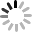

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
# Check the inputs
print(FLAGS.predict_file)
# Original predict_file used for bert on nq
# predict_file=/content/tiny-dev/nq-dev-sample.no-annot.jsonl.gz
!ls /content/tiny-dev/

!zcat /content/tiny-dev/nq-dev-sample.no-annot.jsonl.gz > /content/tiny-dev/nq-dev-sample.no-annot.jsonl

!head /content/tiny-dev/nq-dev-sample.no-annot.jsonl

# Bert on NQ test set
data_line = []
nrows = 10
# read the data
with open('/content/tiny-dev/nq-dev-sample.no-annot.jsonl', 'rt') as f:
    for i in range(nrows):
        data_line.append(json.loads(f.readline()))
 
test_bert_on_nq_df = pd.DataFrame(data_line) # convert to data frame

# Kaggle test set
data_line = []
nrows = 10
# read the data
with open('/content/simplified-nq-test.jsonl', 'rt') as f:
    for i in range(nrows):
        data_line.append(json.loads(f.readline()))
 
test_kaggle_df = pd.DataFrame(data_line) # convert to data frame


In [0]:

print(test_kaggle_df)
print(test_kaggle_df.columns)


             example_id  ...                             long_answer_candidates
0  -1220107454853145579  ...  [{'end_token': 136, 'start_token': 18, 'top_le...
1   8777415633185303067  ...  [{'end_token': 190, 'start_token': 23, 'top_le...
2   4640548859154538040  ...  [{'end_token': 165, 'start_token': 12, 'top_le...
3  -5316095317154496261  ...  [{'end_token': 105, 'start_token': 8, 'top_lev...
4  -8752372642178983917  ...  [{'end_token': 287, 'start_token': 16, 'top_le...
5  -3401345000915256454  ...  [{'end_token': 317, 'start_token': 38, 'top_le...
6   4774513718149377942  ...  [{'end_token': 149, 'start_token': 19, 'top_le...
7   5354793787345685154  ...  [{'end_token': 218, 'start_token': 69, 'top_le...
8   -430548376093792225  ...  [{'end_token': 722, 'start_token': 23, 'top_le...
9   1166366462619398660  ...  [{'end_token': 698, 'start_token': 35, 'top_le...

[10 rows x 4 columns]
Index(['example_id', 'question_text', 'document_text',
       'long_answer_candidates'],
      dt

In [0]:
print('example_id')
print(test_kaggle_df['example_id'][1])
print('question_text')
print(test_kaggle_df['question_text'][1])
print('long_answer_candidates')
print(test_kaggle_df['long_answer_candidates'][1])


example_id
8777415633185303067
question_text
the office episode when they sing to michael
long_answer_candidates
[{'end_token': 190, 'start_token': 23, 'top_level': True}, {'end_token': 34, 'start_token': 24, 'top_level': False}, {'end_token': 41, 'start_token': 34, 'top_level': False}, {'end_token': 54, 'start_token': 41, 'top_level': False}, {'end_token': 64, 'start_token': 54, 'top_level': False}, {'end_token': 74, 'start_token': 64, 'top_level': False}, {'end_token': 83, 'start_token': 74, 'top_level': False}, {'end_token': 96, 'start_token': 83, 'top_level': False}, {'end_token': 106, 'start_token': 96, 'top_level': False}, {'end_token': 115, 'start_token': 106, 'top_level': False}, {'end_token': 137, 'start_token': 115, 'top_level': False}, {'end_token': 135, 'start_token': 117, 'top_level': False}, {'end_token': 125, 'start_token': 118, 'top_level': False}, {'end_token': 134, 'start_token': 125, 'top_level': False}, {'end_token': 143, 'start_token': 137, 'top_level': False}, {'e

In [0]:
print('document_text')
print(test_kaggle_df['document_text'][1])

document_text
Michael 's Last Dundies - wikipedia <H1> Michael 's Last Dundies </H1> <P> </P> 21st episode of the seventh season of The Office <Table> <Tr> <Th_colspan="2"> `` Michael 's Last Dundies '' </Th> </Tr> <Tr> <Td_colspan="2"> The Office episode </Td> </Tr> <Tr> <Th> Episode no . </Th> <Td> Season 7 Episode 21 </Td> </Tr> <Tr> <Th> Directed by </Th> <Td> Mindy Kaling </Td> </Tr> <Tr> <Th> Written by </Th> <Td> Mindy Kaling </Td> </Tr> <Tr> <Th> Production code </Th> <Td> 7021 </Td> </Tr> <Tr> <Th> Original air date </Th> <Td> April 21 , 2011 </Td> </Tr> <Tr> <Th> Running time </Th> <Td> 22 minutes </Td> </Tr> <Tr> <Th_colspan="2"> Guest appearance ( s ) </Th> </Tr> <Tr> <Td_colspan="2"> <Ul> <Li> Will Ferrell as Deangelo Vickers </Li> <Li> Jack Coleman as State Sen. Robert Lipton </Li> </Ul> </Td> </Tr> <Tr> <Th_colspan="2"> Episode chronology </Th> </Tr> <Tr> <Td_colspan="2"> <Table> <Tr> <Td> ← Previous `` Training Day '' </Td> <Td> Next → `` Goodbye , Michael '' </Td> </Tr

In [0]:

print(test_bert_on_nq_df)
print(test_bert_on_nq_df.columns)


                              long_answer_candidates  ...                                    question_tokens
0  [{'start_token': 44, 'top_level': True, 'start...  ...  [what, purpose, did, seasonal, monsoon, winds,...
1  [{'start_token': 18, 'top_level': True, 'start...  ...  [where, did, they, film, high, school, musical...
2  [{'start_token': 41, 'top_level': True, 'start...  ...  [who, got, the, first, nobel, prize, in, physics]
3  [{'start_token': 24, 'top_level': True, 'start...  ...  [who, has, the, rights, to, alice, in, wonderl...
4  [{'start_token': 14, 'top_level': True, 'start...  ...  [when, is, the, next, deadpool, movie, being, ...
5  [{'start_token': 14, 'top_level': True, 'start...  ...  [what, is, the, lowest, recorded, temperature,...
6  [{'start_token': 18, 'top_level': True, 'start...  ...  [when, is, the, next, tangled, the, series, ep...
7  [{'start_token': 26, 'top_level': True, 'start...  ...  [where, did, the, idea, of, fortnite, come, from]
8  [{'start_token':

In [0]:
print('annotations')
print(test_bert_on_nq_df['annotations'][1])
print('long_answer_candidates')
print(test_bert_on_nq_df['long_answer_candidates'][1])
print('question_text')
print(test_bert_on_nq_df['question_text'][1])
print('example_id')
print(test_bert_on_nq_df['example_id'][1])
print('document_url')
print(test_bert_on_nq_df['document_url'][1])
print('document_title')
print(test_bert_on_nq_df['document_title'][1])
print('question_tokens')
print(test_bert_on_nq_df['question_tokens'][1])
print('document_tokens')
print(test_bert_on_nq_df['document_tokens'][1])

long_answer_candidates
[{'start_token': 18, 'top_level': True, 'start_byte': 55211, 'end_token': 260, 'end_byte': 58952}, {'start_token': 19, 'top_level': False, 'start_byte': 55268, 'end_token': 27, 'end_byte': 55477}, {'start_token': 27, 'top_level': False, 'start_byte': 55478, 'end_token': 33, 'end_byte': 55968}, {'start_token': 33, 'top_level': False, 'start_byte': 55969, 'end_token': 43, 'end_byte': 56102}, {'start_token': 43, 'top_level': False, 'start_byte': 56103, 'end_token': 53, 'end_byte': 56239}, {'start_token': 53, 'top_level': False, 'start_byte': 56240, 'end_token': 72, 'end_byte': 56753}, {'start_token': 72, 'top_level': False, 'start_byte': 56754, 'end_token': 84, 'end_byte': 56929}, {'start_token': 84, 'top_level': False, 'start_byte': 56930, 'end_token': 95, 'end_byte': 57002}, {'start_token': 95, 'top_level': False, 'start_byte': 57003, 'end_token': 107, 'end_byte': 57100}, {'start_token': 107, 'top_level': False, 'start_byte': 57101, 'end_token': 112, 'end_byte': 5

<!DOCTYPE html>
<HTML class="client-js ve-not-available" lang="en" dir="ltr"><HEAD>

<TITLE>High School Musical 2 - Wikipedia</TITLE>


<LINK rel="stylesheet" href="/w/load.php?debug=false&amp;lang=en&amp;modules=ext.cite.styles%7Cext.math.styles%7Cext.uls.interlanguage%7Cext.visualEditor.desktopArticleTarget.noscript%7Cext.wikimediaBadges%7Cmediawiki.legacy.commonPrint%2Cshared%7Cmediawiki.sectionAnchor%7Cmediawiki.skinning.interface%7Cskins.vector.styles%7Cwikibase.client.init&amp;only=styles&amp;skin=vector" />

<STYLE>
.referencetooltip{position:absolute;list-style:none;list-style-image:none;opacity:0;font-size:12px;margin:0;z-index:5;padding:0}.referencetooltip > li{background:#fff;border:1px solid #bbb;-webkit-box-shadow:0 0 10px rgba(0,0,0,0.2);-moz-box-shadow:0 0 10px rgba(0,0,0,0.2);box-shadow:0 0 10px rgba(0,0,0,0.2);margin:0;padding:8px 10px;line-height:18px;max-width:300px}.referencetooltip > li + li{box-sizing:border-box;margin-left:7px;margin-top:-1px;border:0;padding:0;h
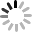

In [0]:
print(test_bert_on_nq_df['document_html'][1])

In [0]:
print('document_text')
print(test_kaggle_df['document_text'][1])
print('document_html')
print(test_bert_on_nq_df['document_html'][1])

In [0]:
print('long_answer_candidates')
print(test_kaggle_df['long_answer_candidates'][1])
print('long_answer_candidates')
print(test_bert_on_nq_df['long_answer_candidates'][1])


long_answer_candidates
[{'end_token': 190, 'start_token': 23, 'top_level': True}, {'end_token': 34, 'start_token': 24, 'top_level': False}, {'end_token': 41, 'start_token': 34, 'top_level': False}, {'end_token': 54, 'start_token': 41, 'top_level': False}, {'end_token': 64, 'start_token': 54, 'top_level': False}, {'end_token': 74, 'start_token': 64, 'top_level': False}, {'end_token': 83, 'start_token': 74, 'top_level': False}, {'end_token': 96, 'start_token': 83, 'top_level': False}, {'end_token': 106, 'start_token': 96, 'top_level': False}, {'end_token': 115, 'start_token': 106, 'top_level': False}, {'end_token': 137, 'start_token': 115, 'top_level': False}, {'end_token': 135, 'start_token': 117, 'top_level': False}, {'end_token': 125, 'start_token': 118, 'top_level': False}, {'end_token': 134, 'start_token': 125, 'top_level': False}, {'end_token': 143, 'start_token': 137, 'top_level': False}, {'end_token': 168, 'start_token': 143, 'top_level': False}, {'end_token': 166, 'start_token':

In [0]:
print('document_tokens')
print(test_bert_on_nq_df['document_tokens'][1])
print('document_tokens length')
print(len(test_bert_on_nq_df['document_tokens'][1]))


document_tokens
[{'start_byte': 92, 'token': 'High', 'html_token': False, 'end_byte': 96}, {'start_byte': 97, 'token': 'School', 'html_token': False, 'end_byte': 103}, {'start_byte': 104, 'token': 'Musical', 'html_token': False, 'end_byte': 111}, {'start_byte': 112, 'token': '2', 'html_token': False, 'end_byte': 113}, {'start_byte': 114, 'token': '-', 'html_token': False, 'end_byte': 115}, {'start_byte': 116, 'token': 'Wikipedia', 'html_token': False, 'end_byte': 125}, {'start_byte': 54712, 'token': '<H1>', 'html_token': True, 'end_byte': 54765}, {'start_byte': 54768, 'token': 'High', 'html_token': False, 'end_byte': 54772}, {'start_byte': 54773, 'token': 'School', 'html_token': False, 'end_byte': 54779}, {'start_byte': 54780, 'token': 'Musical', 'html_token': False, 'end_byte': 54787}, {'start_byte': 54788, 'token': '2', 'html_token': False, 'end_byte': 54789}, {'start_byte': 54793, 'token': '</H1>', 'html_token': True, 'end_byte': 54798}, {'start_byte': 55013, 'token': 'Jump', 'html_

## NQ_Train.tfrecord - investigation

In [0]:
# nq-train.tfrecords-00000-of-00001
!ls /content/bert-joint-baseline
nq_train = tf.data.TFRecordDataset('/content/bert-joint-baseline/nq-train.tfrecords-00000-of-00001')

bert_config.json		     nq-train.tfrecords-00000-of-00001
bert_joint.ckpt.data-00000-of-00001  vocab-nq.txt
bert_joint.ckpt.index


In [0]:
# input_fn_builder from run_nq
seq_length = FLAGS.max_seq_length
name_to_features = {
      "unique_ids": tf.FixedLenFeature([], tf.int64),
      "input_ids": tf.FixedLenFeature([], tf.int64),
      "input_mask": tf.FixedLenFeature([seq_length], tf.int64),
      "segment_ids": tf.FixedLenFeature([seq_length], tf.int64),
  }

# if is_training:
name_to_features["start_positions"] = tf.FixedLenFeature([], tf.int64)
name_to_features["end_positions"] = tf.FixedLenFeature([], tf.int64)
name_to_features["answer_types"] = tf.FixedLenFeature([], tf.int64)
    
def _decode_record(record, name_to_features):
  """Decodes a record to a TensorFlow example."""
  example = tf.parse_single_example(record, name_to_features)

  # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
  # So cast all int64 to int32.
  for name in list(example.keys()):
    t = example[name]
    if t.dtype == tf.int64:
      t = tf.to_int32(t)
    example[name] = t

  return example

nq_train.

nq_train_1 = nq_train.apply(
    tf.data.experimental.map_and_batch(
        lambda record: _decode_record(record, name_to_features),
        batch_size=1,
        drop_remainder=True))



In [0]:
# Source: https://groups.google.com/forum/#!topic/youtube8m-users/CUpvqDDHaxw
print(type(nq_train))

print(nq_train_1)
print(type(nq_train_1))
# tf.python.data.ops.dataset_ops.DatasetV1Adapter.
# for example in tf.python_io.tf_record_iterator(nq_train):
#   print(tf.train.Example.FromString(example))

for idx, example in enumerate(tf.python_io.tf_record_iterator('/content/bert-joint-baseline/nq-train.tfrecords-00000-of-00001')):
  
  a = (tf.train.Example.FromString(example))
  if idx > 1:
    break

print(a)
# {answer_types: (1,), end_positions: (1,), input_ids: (1,), input_mask: (1, 512),
#  segment_ids: (1, 512), start_positions: (1,), unique_ids: (1,)}, 
#  types: {answer_types: tf.int32, end_positions: tf.int32, input_ids: tf.int32, 
#          input_mask: tf.int32, segment_ids: tf.int32, start_positions: tf.int32,
#          unique_ids: tf.int32}


<class 'tensorflow.python.data.ops.readers.TFRecordDatasetV1'>
<DatasetV1Adapter shapes: {answer_types: (1,), end_positions: (1,), input_ids: (1,), input_mask: (1, 512), segment_ids: (1, 512), start_positions: (1,), unique_ids: (1,)}, types: {answer_types: tf.int32, end_positions: tf.int32, input_ids: tf.int32, input_mask: tf.int32, segment_ids: tf.int32, start_positions: tf.int32, unique_ids: tf.int32}>
<class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>
features {
  feature {
    key: "answer_types"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "end_positions"
    value {
      int64_list {
        value: 93
      }
    }
  }
  feature {
    key: "input_ids"
    value {
      int64_list {
        value: 101
        value: 104
        value: 2129
        value: 2116
        value: 4178
        value: 2003
        value: 1996
        value: 2990
        value: 4575
        value: 2186
        value: 102
        value: 259
        v

### Delete all flags function

In [0]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)

### prepare_nq_data.py

In [0]:
# prepare_nq_data.py

import gzip
import random
# from language.question_answering.bert_joint import run_nq
# import tensorflow as tf

flags = tf.flags
FLAGS = flags.FLAGS

flags.DEFINE_string(
    "input_jsonl", '/content/simplified-nq-test.jsonl',
    "Gzipped files containing NQ examples in Json format, one per line.")

flags.DEFINE_string("output_tfrecord", None,
                    "Output tf record file with all features extracted.")

flags.DEFINE_bool(
    "is_training", True,
    "Whether to prepare features for training or for evaluation. Eval features "
    "don't include gold labels, but include wordpiece to html token maps.")

flags.DEFINE_integer(
    "max_examples", 0,
    "If positive, stop once these many examples have been converted.")


def get_examples(input_jsonl_pattern):
  for input_path in tf.gfile.Glob(input_jsonl_pattern):
    with gzip.GzipFile(fileobj=tf.gfile.Open(input_path)) as input_file:
      for line in input_file:
        yield tf1nq.create_example_from_jsonl(line)

def get_examples_jsonl(input_jsonl):
  with open(input_jsonl, 'rt') as f:
      for line in f:
        yield tf1nq.create_example_from_jsonl(line)


examples_processed = 0
num_examples_with_correct_context = 0
creator_fn = tf1nq.CreateTFExampleFn(is_training=FLAGS.is_training)

instances = []
for example in get_examples_jsonl(FLAGS.input_jsonl):
  for instance in creator_fn.process(example):
    instances.append(instance)
  if example["has_correct_context"]:
    num_examples_with_correct_context += 1
  if examples_processed % 100 == 0:
    tf.logging.info("Examples processed: %d", examples_processed)
  examples_processed += 1
  if FLAGS.max_examples > 0 and examples_processed >= FLAGS.max_examples:
    break
tf.logging.info("Examples with correct context retained: %d of %d",
                num_examples_with_correct_context, examples_processed)

# Writing to tfrecord. Look at instances - object before writing to tfrecord
random.shuffle(instances)
with tf.python_io.TFRecordWriter(FLAGS.output_tfrecord) as writer:
  for instance in instances:
    writer.write(instance)



KeyError: ignored

## Rest of the prediction codes

In [0]:
if FLAGS.do_predict:
  def append_feature(feature):
    eval_features.append(feature)
    eval_writer.process_feature(feature)

  num_spans_to_ids = tf1nq.convert_examples_to_features(
      examples=eval_examples,
      tokenizer=tokenizer,
      is_training=False,
      output_fn=append_feature)
  eval_writer.close()
  eval_filename = eval_writer.filename

  tf.logging.info("***** Running predictions *****")
  tf.logging.info("  Num orig examples = %d", len(eval_examples))
  tf.logging.info("  Num split examples = %d", len(eval_features))
  tf.logging.info("  Batch size = %d", FLAGS.predict_batch_size)
  # Modified - Isaac
  # for spans, ids in num_spans_to_ids.iteritems():
  for spans, ids in num_spans_to_ids.items():
    tf.logging.info("  Num split into %d = %d", spans, len(ids))

  predict_input_fn = tf1nq.input_fn_builder(
      input_file=eval_filename,
      seq_length=FLAGS.max_seq_length,
      is_training=False,
      drop_remainder=False)
if FLAGS.do_predict:

  # If running eval on the TPU, you will need to specify the number of steps.
  all_results = []
  for result in estimator.predict(
      predict_input_fn, yield_single_examples=True):
    if len(all_results) % 1000 == 0:
      tf.logging.info("Processing example: %d" % (len(all_results)))
    unique_id = int(result["unique_ids"])
    start_logits = [float(x) for x in result["start_logits"].flat]
    end_logits = [float(x) for x in result["end_logits"].flat]
    answer_type_logits = [float(x) for x in result["answer_type_logits"].flat]
    all_results.append(
        tf1nq.RawResult(
            unique_id=unique_id,
            start_logits=start_logits,
            end_logits=end_logits,
            answer_type_logits=answer_type_logits))

  candidates_dict = tf1nq.read_candidates(FLAGS.predict_file)
  eval_features = [
      tf.train.Example.FromString(r)
      for r in tf.python_io.tf_record_iterator(eval_filename)
  ]
  nq_pred_dict = tf1nq.compute_pred_dict(candidates_dict, eval_features,
                                    [r._asdict() for r in all_results])
  predictions_json = {"predictions": nq_pred_dict.values()}
  with tf.gfile.Open(FLAGS.output_prediction_file, "w") as f:
    json.dump(predictions_json, f, indent=4)

INFO:tensorflow:***** Running predictions *****
INFO:tensorflow:  Num orig examples = 346
INFO:tensorflow:  Num split examples = 9070
INFO:tensorflow:  Batch size = 8
INFO:tensorflow:  Num split into 2 = 8
INFO:tensorflow:  Num split into 18 = 9
INFO:tensorflow:  Num split into 49 = 5
INFO:tensorflow:  Num split into 1 = 13
INFO:tensorflow:  Num split into 33 = 6
INFO:tensorflow:  Num split into 53 = 1
INFO:tensorflow:  Num split into 39 = 7
INFO:tensorflow:  Num split into 41 = 3
INFO:tensorflow:  Num split into 21 = 7
INFO:tensorflow:  Num split into 10 = 12
INFO:tensorflow:  Num split into 28 = 8
INFO:tensorflow:  Num split into 101 = 1
INFO:tensorflow:  Num split into 59 = 3
INFO:tensorflow:  Num split into 9 = 12
INFO:tensorflow:  Num split into 20 = 6
INFO:tensorflow:  Num split into 40 = 4
INFO:tensorflow:  Num split into 5 = 7
INFO:tensorflow:  Num split into 34 = 8
INFO:tensorflow:  Num split into 22 = 4
INFO:tensorflow:  Num split into 31 = 7
INFO:tensorflow:  Num split into 

In [0]:
print(FLAGS.output_prediction_file)

NameError: ignored

# Final note on prediction using original bert on nq code
document_tokens

In [0]:
# Summary notes before moving on
# document_tokens is the key road block.
# In the bert nq original test set, nq-dev-sample.no-annot.jsonl
# One part of the input is document_tokens which is basically each word, 
# whether it's a html keyword or an actually word, converted to start byte, 
# end byte, HTML_flag, and token. The original bert model takes in this
# document_tokens and there is no way around it, other than changing the 
# original model. Both training set and test set provided by the original bert 
# on NQ has document_tokens. 
# I tried to find a way to generate document_tokens using given functions such 
# as prepare_nq_data.py but no luck. There is no mechanism in the code to 
# convert a raw document in simplified-nq-test/train.jsonl to document_tokens.
# I searched all the run_nq.py for functions to convert the raw data into
# document_tokens and still no luck. I looked at tokenizer file as well but
# there is no function to convert to document_tokens.

# So given this search, I'm moving onto looking at the kaggle notebook and find
# a solution there. I've given up converting document_tokens altogether. 
# I think what will happen is I'm going to skip document_tokens entirely. Let's
# see what will happen next.
# One thing to do is to organize the draft work in one section and shrink it.
# The codes below this are the rest of the prediction codes that I was not able
# to reach after failing to execute the first part, after which I started this
# investigation. So include it in the code folding.

# Notes added: So training came to my mind. The training also used the 
# packaged data. I think they used prepare_nq_data.py to generate the training
# data and this function also requires document_tokens. So even the training
# was not actually successful. I can't use other data. I can try but I doubt
# it will work. 
# IMPORTANT: When I ran with the output folder outdir and set the iteration to 
# 1000, then the train code didn't execute saying that the number of epochs
# already exceeded the number of training. Meaning that the training starts
# where it left off! So the model remembers! So when continuing the training
# I can run the same code and it will start from the checkpoint! (if the 
# training set and all the other setting are the same of course)
# I ran this. I fed in the kaggle training set and it fails. I don't know why
# but it fails to train. Two possible reasons. One is that the kaggle data
# is in json format not in tfrecord format. The second is because of 
# document_tokens but I couldn't find any error associated with document_tokens
# Check the tfrecord of original train file and see what's in there.
# I did the above. Here is the information. Note that they are all int - even
# words - already encoded
# {answer_types: (1,), end_positions: (1,), input_ids: (1,), input_mask: (1, 512),
#  segment_ids: (1, 512), start_positions: (1,), unique_ids: (1,)}, 
#  types: {answer_types: tf.int32, end_positions: tf.int32, input_ids: tf.int32, 
#          input_mask: tf.int32, segm

# Now let's look at the prediction in Kaggle notebook
# Here I'm looking for the preprocessing part only. Don't get mixed up in the 
# post-processing. from raw data to input arrays (segment_ids, input_ids, and
# input_mask). 
# Also, another objective is to find out the operations involved with 
# document_tokens and how the usage of document_tokens are eliminated in the 
# kaggle code. And then the ultimate goal is to modify the original code
# so that I can at least I can predict using the modified original code combined
# with the pre-processing code above.
# Now to train, the final piece of the puzzle is to know the post-process.
# At this point in time, I'm not sure if I need to process it or I can use
# the given information. But this is for the next phase.

# In order to look at the mechanism, I'm going to build a function pipeline to
# compare where I can remove document_tokens
# Let me first isolate the pre-processing part. Actually, I'll just do the
# whole thing, then I'll isolate the pre-processing. That might be easier.
# Comparison made in
# C:\Users\diman\OneDrive\Work_temp\Insight\Kaggle Competition Insight Team\kaggleandoriginal_prediction_comparison




# Rest of the notebook code

In [0]:
!ls outdir/ -l --block-size=M
!ls bert-joint-baseline/ -l --block-size=M

total 0M
total 2345M
-rw-r--r-- 1 root root    1M Feb  2 02:36 bert_config.json
-rw-r--r-- 1 root root 1279M Feb  2 02:36 bert_joint.ckpt.data-00000-of-00001
-rw-r--r-- 1 root root    1M Feb  2 02:36 bert_joint.ckpt.index
-rw-r--r-- 1 root root 1067M Feb  2 02:36 nq-train.tfrecords-00000-of-00001
-rw-r--r-- 1 root root    1M Feb  2 02:36 vocab-nq.txt


Now, we turn predictions.json into a submission.csv file.

In [0]:
test_answers_df = pd.read_json(address3+"predictions.json")

The Bert model produces a confidence score, which the Kaggle metric does not use. You, however, can use that score to determine which answers get submitted. See the limits commented out in create_short_answer and create_long_answer below for an example.

Values for confidence will range between 1.0 and 2.0.

In [0]:
def create_short_answer(entry):
    # if entry["short_answers_score"] < 1.5:
    #     return ""
    
    answer = []    
    for short_answer in entry["short_answers"]:
        if short_answer["start_token"] > -1:
            answer.append(str(short_answer["start_token"]) + ":" + str(short_answer["end_token"]))
    if entry["yes_no_answer"] != "NONE":
        answer.append(entry["yes_no_answer"])
    return " ".join(answer)

def create_long_answer(entry):
   # if entry["long_answer_score"] < 1.5:
   # return ""

    answer = []
    if entry["long_answer"]["start_token"] > -1:
        answer.append(str(entry["long_answer"]["start_token"]) + ":" + str(entry["long_answer"]["end_token"]))
    return " ".join(answer)
test_answers_df["long_answer_score"] = test_answers_df["predictions"].apply(lambda q: q["long_answer_score"])
test_answers_df["short_answer_score"] = test_answers_df["predictions"].apply(lambda q: q["short_answers_score"])
test_answers_df["long_answer_score"].describe()


count    346.000000
mean       0.901300
std        0.250180
min        0.000000
25%        0.866473
50%        0.946224
75%        1.027903
max        1.332606
Name: long_answer_score, dtype: float64

An example of what each sample's answers look like in prediction.json:

In [0]:
test_answers_df.predictions.values[0]

{'example_id': '-1220107454853145579',
 'long_answer': {'end_byte': -1,
  'end_token': 336,
  'start_byte': -1,
  'start_token': 240},
 'long_answer_score': 1.143175601959228,
 'short_answers': [{'end_byte': -1,
   'end_token': 275,
   'start_byte': -1,
   'start_token': 271}],
 'short_answers_score': 1.143175601959228,
 'yes_no_answer': 'NONE'}

We re-format the JSON answers to match the requirements for submission.

In [0]:
test_answers_df["long_answer"] = test_answers_df["predictions"].apply(create_long_answer)
test_answers_df["short_answer"] = test_answers_df["predictions"].apply(create_short_answer)
test_answers_df["example_id"] = test_answers_df["predictions"].apply(lambda q: str(q["example_id"]))

long_answers = dict(zip(test_answers_df["example_id"], test_answers_df["long_answer"]))
short_answers = dict(zip(test_answers_df["example_id"], test_answers_df["short_answer"]))

Then we add them to our sample submission. Recall that each sample has both a _long and _short entry in the sample submission, one for each type of answer.

In [0]:
sample_submission = pd.read_csv(address2+"sample_submission.csv")

long_prediction_strings = sample_submission[sample_submission["example_id"].str.contains("_long")].apply(lambda q: long_answers[q["example_id"].replace("_long", "")], axis=1)
short_prediction_strings = sample_submission[sample_submission["example_id"].str.contains("_short")].apply(lambda q: short_answers[q["example_id"].replace("_short", "")], axis=1)

sample_submission.loc[sample_submission["example_id"].str.contains("_long"), "PredictionString"] = long_prediction_strings
sample_submission.loc[sample_submission["example_id"].str.contains("_short"), "PredictionString"] = short_prediction_strings



And finally, we write out our submission!

In [0]:
sample_submission.to_csv("submission.csv", index=False)
sample_submission.head()
!cp /content/submission.csv /gdrive/'My Drive'/kaggle/

!cp -r /content/outdir/. /gdrive/'My Drive'/kaggle/outdir/

example_id PredictionString
0   -1011141123527297803_long          339:513
1  -1011141123527297803_short          427:440
2   -1028916936938579349_long           42:321
3  -1028916936938579349_short          244:268
4   -1055197305756217938_long          221:335

next job: get bert_utils(tf2_0_baseline_w_bert), modeling, tokenization, optimization...

In [0]:
!ls
!ls \outdir

eval.tf_record


In [0]:
!zcat simplified-nq-train.jsonl.zip | head -n 1000 > /content/simplified-nq-train_1000.jsonl
!cp /content/simplified-nq-train_1000.jsonl /gdrive/'My Drive'/kaggle/BERT_ON_NQ/